#### 1. Loading the required libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import joblib
import os
import numpy as np
import pandas as pd


import librosa
import librosa.display
from scipy import signal
from base64 import b64decode
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib import style
from IPython.display import Javascript, Audio
import seaborn as sn
from PIL import Image

import tqdm
!pip install pydub
import pydub
from pydub import AudioSegment

from google.colab import drive, output

style.use('Solarize_Light2')

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
target_folder = "gdrive/My Drive" # Please change this if required

SAMPLE_RATE = 16000
BATCH_SIZE  = 64
SPLITS = ['train', 'validation', 'test']
generate_features = True

#### 2. Setup

In [ ]:
root_location           = os.path.join(target_folder, "speech_commands")
raw_data_location       = os.path.join(root_location, "data/raw")
processed_data_location = os.path.join(root_location, "data/processed")
model_location          = os.path.join(root_location, "models")

locations = [root_location, raw_data_location, processed_data_location, model_location]

for location in locations:
  result = os.makedirs(location, exist_ok=True)

#### 3. Loading the datasets

In [ ]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'speech_commands',
    split = SPLITS,
    shuffle_files = True,
    as_supervised = False,
    with_info = True,
    data_dir = raw_data_location
)

#### 4. Feature generation: MFCC using Librosa

In [ ]:
def audio_to_mfcc(samples):

    samples = np.pad(samples, (0,SAMPLE_RATE-len(samples)), 'linear_ramp')

    mfcc = librosa.feature.mfcc(samples, sr = SAMPLE_RATE, n_mfcc=16).T

    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')

    return delta2_mfcc

def create_dataset(dataset_type = 'train'):
  
  no_of_observations = ds_info.splits[dataset_type].num_examples
  if dataset_type == 'train':
    input_data = ds_train
  
  elif dataset_type == 'validation':
    input_data = ds_validation
  
  else : 
    input_data = ds_test

  X = np.zeros([no_of_observations,32,16])
  y = np.zeros([no_of_observations]) 

  for i, observation in enumerate(input_data):

    samples = tf.cast(observation['audio'], dtype = 'float32').numpy()

    X[i] = audio_to_mfcc(samples)

    label   = observation['label']

    y[i] = label
  
  _X = np.expand_dims(X, axis=3)

  return _X, y

In [ ]:
# Creating the train, test & validation datasets

generate_features = not os.path.isfile(os.path.join(processed_data_location, 'X_train.npy')) 

if generate_features:
  for split in tqdm.tqdm(SPLITS):
    exec("X_{0}, y_{0} = create_dataset(dataset_type='{0}')".format(split))

  np.save(os.path.join(processed_data_location, 'X_train.npy'), X_train)
  np.save(os.path.join(processed_data_location, 'y_train.npy'), y_train)

  np.save(os.path.join(processed_data_location, 'X_test.npy'), X_test)
  np.save(os.path.join(processed_data_location, 'y_test.npy'), y_test)

  np.save(os.path.join(processed_data_location, 'X_val.npy'), X_validation)
  np.save(os.path.join(processed_data_location, 'y_val.npy'), y_validation)

else:

  X_train = np.load(os.path.join(processed_data_location, 'X_train.npy'))
  y_train = np.load(os.path.join(processed_data_location, 'y_train.npy'))

  X_test = np.load(os.path.join(processed_data_location, 'X_test.npy'))
  y_test = np.load(os.path.join(processed_data_location, 'y_test.npy'))

  X_validation = np.load(os.path.join(processed_data_location, 'X_val.npy'))
  y_validation = np.load(os.path.join(processed_data_location, 'y_val.npy'))



#### Model development


##### Approach 1: Basic CNN 

In [ ]:
input_shape = X_train.shape[1:]

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu', name="feature_layer"))
model.add(Dropout(0.5))
model.add(Dense(12))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
weights       = compute_class_weight(class_weight = None, classes = np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))

In [ ]:
checkpointer = ModelCheckpoint(filepath = os.path.join(model_location, "{}_best.h5".format("CNN")),
                               verbose=0,
                               save_best_only=True)

history = model.fit(X_train, 
                   to_categorical(y_train), 
                   batch_size = BATCH_SIZE, 
                   epochs = 50, 
                   verbose = 1, shuffle = True, 
                   validation_data = (X_validation, to_categorical(y_validation)),
                   #class_weight = class_weights,
                   callbacks = [checkpointer]) 

Epoch 1/50
1337/1337 [==============================] - 5s 3ms/step - loss: 1.2777 - accuracy: 0.6492 - val_loss: 0.8521 - val_accuracy: 0.7309
Epoch 2/50
1337/1337 [==============================] - 5s 3ms/step - loss: 0.8454 - accuracy: 0.7221 - val_loss: 0.6023 - val_accuracy: 0.7947
Epoch 3/50
1337/1337 [==============================] - 4s 3ms/step - loss: 0.6753 - accuracy: 0.7785 - val_loss: 0.4864 - val_accuracy: 0.8423
Epoch 4/50
1337/1337 [==============================] - 4s 3ms/step - loss: 0.5817 - accuracy: 0.8075 - val_loss: 0.4358 - val_accuracy: 0.8574
Epoch 5/50
1337/1337 [==============================] - 4s 3ms/step - loss: 0.5271 - accuracy: 0.8282 - val_loss: 0.3895 - val_accuracy: 0.8756
Epoch 6/50
1337/1337 [==============================] - 4s 3ms/step - loss: 0.4823 - accuracy: 0.8421 - val_loss: 0.3704 - val_accuracy: 0.8842
Epoch 7/50
1337/1337 [==============================] - 4s 3ms/step - loss: 0.4506 - accuracy: 0.8525 - val_loss: 0.3438 - val_accuracy:

In [ ]:
model_basic_cnn = load_model(os.path.join(model_location, "{}_best.h5".format("CNN")))

##### Approach 2: Basic CNN features + Standard ML classifiers 

In [ ]:
model_basic_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 14, 32)        320       
_________________________________________________________________
activation_12 (Activation)   (None, 30, 14, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 7, 32)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 5, 32)         9248      
_________________________________________________________________
activation_13 (Activation)   (None, 13, 5, 32)         0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 2, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 384)              

In [ ]:
model_output = model_basic_cnn.get_layer("feature_layer").output # Please change if required. 
model_cnn_for_features = Model(inputs=model_basic_cnn.input, outputs=model_output)
model_cnn_for_features.save(os.path.join(model_location, "{}_best.h5".format("CNN+NB_1")))

In [ ]:
X_train_cnn = model_cnn_for_features.predict(X_train)
X_val_cnn   = model_cnn_for_features.predict(X_validation)
X_test_cnn  = model_cnn_for_features.predict(X_test)

In [ ]:
classifiers = {"Decision Tree": DecisionTreeClassifier(), 
               "Naive Bayes": GaussianNB(), 
               "Logistic Regression": LogisticRegression(n_jobs = -1),
               "Random Forest": RandomForestClassifier(n_jobs = -1), 
               "XGBoost": XGBClassifier( n_jobs = -1)}

for classifier in classifiers.keys():
  clf = classifiers[classifier]
  
  clf.fit(X_train_cnn, y_train)

  print("Model: {}".format(classifier))
  print("=============================")
  print("Train accuracy: {:.2f}".format(accuracy_score(y_train, clf.predict(X_train_cnn)))) 
  print("Validation accuracy: {:.2f}".format(accuracy_score(y_validation, clf.predict(X_val_cnn)))) 
  print("Test accuracy: {:.2f}".format(accuracy_score(y_test, clf.predict(X_test_cnn)))) 
  print("-----------------------------")

  print()

Model: Decision Tree
Train accuracy: 1.00
Validation accuracy: 0.86
Test accuracy: 0.78
-----------------------------

Model: Naive Bayes
Train accuracy: 0.87
Validation accuracy: 0.86
Test accuracy: 0.86
-----------------------------

Model: Logistic Regression
Train accuracy: 0.94
Validation accuracy: 0.91
Test accuracy: 0.83
-----------------------------

Model: Random Forest
Train accuracy: 1.00
Validation accuracy: 0.91
Test accuracy: 0.82
-----------------------------

Model: XGBoost
Train accuracy: 0.93
Validation accuracy: 0.91
Test accuracy: 0.82
-----------------------------



In [ ]:
model_cnn_nb = GaussianNB()
model_cnn_nb.fit(X_train_cnn, y_train)

joblib.dump(model_cnn_nb, os.path.join(model_location, "{}_best.pkl".format("CNN+NB_2")))

['gdrive/My Drive/speech_commands/models/CNN+NB_2_best.pkl']

##### Approach 3: ResNet50 V2

In [ ]:
model_resnet50_v2 = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights=None,
    input_tensor=Input(shape=(32,16, 1)), 
    classes = 12)

In [ ]:
model_resnet50_v2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath = os.path.join(model_location, "{}_best.h5".format("ResNet50")),
                               verbose=0,
                               save_best_only=True)

history = model_resnet50_v2.fit(X_train, 
                                to_categorical(y_train), 
                                batch_size = BATCH_SIZE, 
                                epochs = 50, 
                                verbose = 1, shuffle = True, 
                                validation_data = (X_validation, to_categorical(y_validation)),
                                callbacks = [checkpointer]) 

Epoch 1/50
1337/1337 [==============================] - 54s 40ms/step - loss: 0.9233 - accuracy: 0.7175 - val_loss: 1.1409 - val_accuracy: 0.6441
Epoch 2/50
1337/1337 [==============================] - 51s 38ms/step - loss: 0.5381 - accuracy: 0.8232 - val_loss: 1.6741 - val_accuracy: 0.5355
Epoch 3/50
1337/1337 [==============================] - 53s 40ms/step - loss: 0.4841 - accuracy: 0.8432 - val_loss: 0.7075 - val_accuracy: 0.7590
Epoch 4/50
1337/1337 [==============================] - 51s 38ms/step - loss: 0.4182 - accuracy: 0.8671 - val_loss: 2461.8225 - val_accuracy: 0.6206
Epoch 5/50
1337/1337 [==============================] - 51s 38ms/step - loss: 0.7466 - accuracy: 0.7818 - val_loss: 3.5007 - val_accuracy: 0.5093
Epoch 6/50
1337/1337 [==============================] - 51s 38ms/step - loss: 0.7691 - accuracy: 0.7572 - val_loss: 1.2554 - val_accuracy: 0.6117
Epoch 7/50
1337/1337 [==============================] - 51s 38ms/step - loss: 0.5891 - accuracy: 0.8108 - val_loss: 0.927

In [ ]:
model_rn = load_model(os.path.join(model_location, "{}_best.h5".format("ResNet50")))

##### Approach 4: ResNet50 V2 features + standard ML classifiers

In [ ]:
model_output = model_rn.get_layer("avg_pool").output # Please change if required. 
model_rn_for_features = Model(inputs=model_rn.input, outputs=model_output)
model_rn_for_features.save(os.path.join(model_location, "{}_best.h5".format("ResNet50+NB_1")))

In [ ]:
X_train_rn = model_rn_for_features.predict(X_train)
X_val_rn   = model_rn_for_features.predict(X_validation)
X_test_rn  = model_rn_for_features.predict(X_test)

In [ ]:
classifiers = {"Decision Tree": DecisionTreeClassifier(), 
               "Naive Bayes": GaussianNB(), 
               "Logistic Regression": LogisticRegression(n_jobs = -1),
               "Random Forest": RandomForestClassifier(n_jobs = -1), 
               "Light GBM": LGBMClassifier(n_jobs = -1)}

for classifier in classifiers.keys():
  clf = classifiers[classifier]
  
  clf.fit(X_train_rn, y_train)

  print("Model: {}".format(classifier))
  print("=============================")
  print("Train accuracy: {:.2f}".format(accuracy_score(y_train, clf.predict(X_train_rn)))) 
  print("Validation accuracy: {:.2f}".format(accuracy_score(y_validation, clf.predict(X_val_rn)))) 
  print("Test accuracy: {:.2f}".format(accuracy_score(y_test, clf.predict(X_test_rn)))) 
  print("-----------------------------")

  print()

Model: Decision Tree
Train accuracy: 1.00
Validation accuracy: 0.92
Test accuracy: 0.84
-----------------------------

Model: Naive Bayes
Train accuracy: 0.83
Validation accuracy: 0.81
Test accuracy: 0.88
-----------------------------

Model: Logistic Regression
Train accuracy: 0.98
Validation accuracy: 0.94
Test accuracy: 0.87
-----------------------------

Model: Random Forest
Train accuracy: 1.00
Validation accuracy: 0.94
Test accuracy: 0.87
-----------------------------

Model: Light GBM
Train accuracy: 1.00
Validation accuracy: 0.94
Test accuracy: 0.87
-----------------------------



In [ ]:
model_rn_nb = GaussianNB()
model_rn_nb.fit(X_train_rn, y_train)

joblib.dump(model_rn_nb, os.path.join(model_location, "{}_best.pkl".format("ResNet50+NB_2")))

['gdrive/My Drive/speech_commands/models/ResNet50+NB_2_best.pkl']

#### Evaluation

In [ ]:
labels = []
for label in np.unique(y_train): 
  label_int = np.int(label)
  labels.append(ds_info.features["label"].int2str(np.int(label_int)))

def evaluate(y_true, y_pred, labels = labels):
  
  print(classification_report(y_test, np.argmax(y_pred, axis = 1), target_names = labels, digits = 3))
  array = confusion_matrix(y_test,np.argmax(y_pred, axis=1))       
  df_cm = pd.DataFrame(array, index=labels,
                    columns=labels)
  plt.figure(figsize = (12,10))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, annot=df_cm.astype(int) ,annot_kws={"size": 16}, fmt='d')# font size

Basic CNN model
77/77 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

        down      0.960     0.707     0.814       406
          go      0.837     0.679     0.750       402
        left      0.951     0.801     0.870       412
          no      0.841     0.743     0.789       405
         off      0.931     0.811     0.867       402
          on      0.936     0.742     0.828       396
       right      0.980     0.851     0.911       396
        stop      0.986     0.886     0.933       411
          up      0.877     0.856     0.867       425
         yes      0.978     0.866     0.919       419
   _silence_      1.000     0.875     0.933       408
   _unknown_      0.380     0.968     0.546       408

    accuracy                          0.816      4890
   macro avg      0.888     0.816     0.836      4890
weighted avg      0.888     0.816     0.836      4890



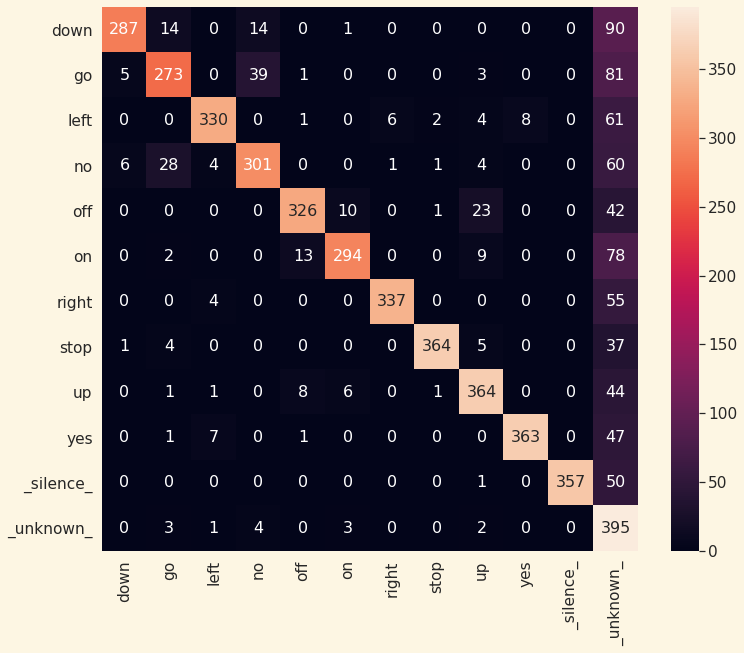

In [ ]:
print("Basic CNN model")
y_pred = model_basic_cnn.predict(X_test, batch_size = BATCH_SIZE, verbose = 1)
evaluate(y_true= y_test, y_pred = y_pred)

Basic CNN features + Naive Bayes
              precision    recall  f1-score   support

        down      0.833     0.833     0.833       406
          go      0.746     0.774     0.759       402
        left      0.883     0.883     0.883       412
          no      0.795     0.778     0.787       405
         off      0.910     0.803     0.853       402
          on      0.837     0.854     0.845       396
       right      0.953     0.912     0.932       396
        stop      0.951     0.905     0.928       411
          up      0.843     0.873     0.858       425
         yes      0.960     0.916     0.938       419
   _silence_      1.000     0.912     0.954       408
   _unknown_      0.672     0.853     0.752       408

    accuracy                          0.858      4890
   macro avg      0.865     0.858     0.860      4890
weighted avg      0.865     0.858     0.860      4890



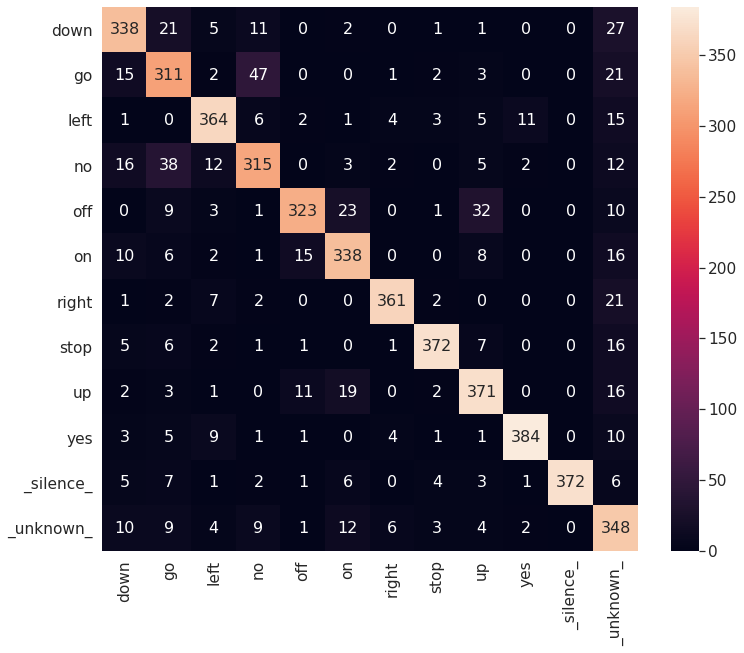

In [ ]:
print("Basic CNN features + Naive Bayes")

X_test_cnn  = model_cnn_for_features.predict(X_test)
y_pred = model_cnn_nb.predict_proba(X_test_cnn)

evaluate(y_true= y_test, y_pred = y_pred)

ResNet50 V2
 1/77 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0054s vs `on_predict_batch_end` time: 0.0105s). Check your callbacks.


77/77 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

        down      0.933     0.823     0.874       406
          go      0.858     0.799     0.827       402
        left      0.948     0.842     0.892       412
          no      0.808     0.862     0.834       405
         off      0.957     0.876     0.914       402
          on      0.940     0.836     0.885       396
       right      0.989     0.874     0.928       396
        stop      0.995     0.881     0.934       411
          up      0.971     0.864     0.914       425
         yes      0.935     0.957     0.946       419
   _silence_      1.000     0.902     0.948       408
   _unknown_      0.527     0.971     0.683       408

    accuracy                          0.874      4890
   macro avg      0.905     0.874     0.882      4890
weighted avg      0.905     0.874     0.882      4890



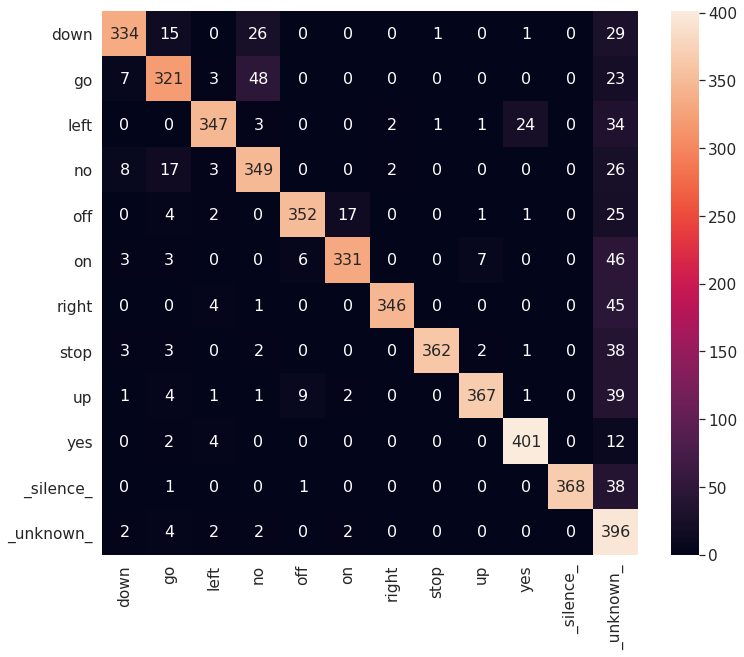

In [ ]:
print("ResNet50 V2")
y_pred = model_rn.predict(X_test, batch_size = BATCH_SIZE, verbose = 1)
evaluate(y_true= y_test, y_pred = y_pred)

ResNet50 V2 features + Naive Bayes
              precision    recall  f1-score   support

        down      0.830     0.879     0.854       406
          go      0.860     0.746     0.799       402
        left      0.872     0.908     0.889       412
          no      0.791     0.859     0.824       405
         off      0.967     0.868     0.915       402
          on      0.817     0.912     0.862       396
       right      0.934     0.927     0.930       396
        stop      0.902     0.937     0.919       411
          up      0.894     0.913     0.903       425
         yes      0.955     0.962     0.958       419
   _silence_      1.000     0.895     0.944       408
   _unknown_      0.796     0.777     0.787       408

    accuracy                          0.882      4890
   macro avg      0.885     0.882     0.882      4890
weighted avg      0.885     0.882     0.882      4890



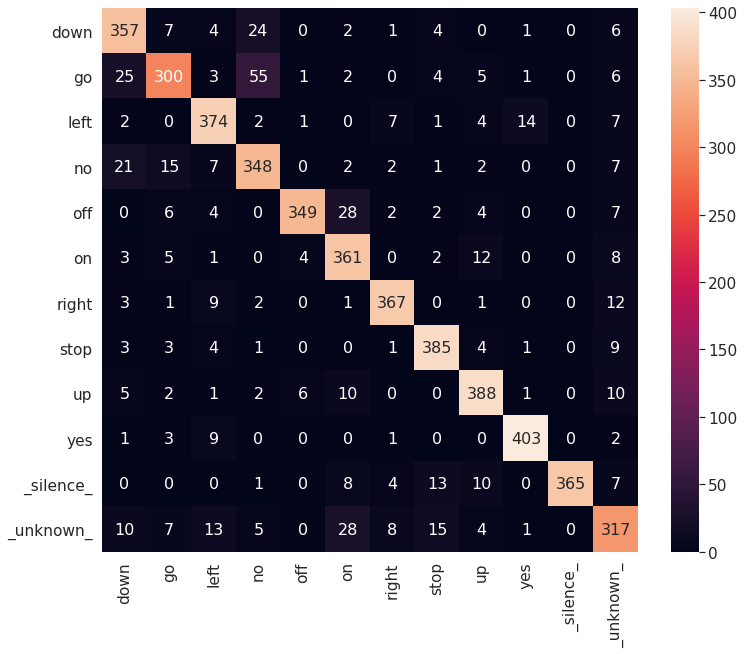

In [ ]:
print("ResNet50 V2 features + Naive Bayes")

X_test_rn  = model_rn_for_features.predict(X_test)
y_pred = model_rn_nb.predict_proba(X_test_rn)

evaluate(y_true= y_test, y_pred = y_pred)

### 7. Speak & Test now !!!

In [ ]:
# Source - https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  print("Speak now...")
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

In [ ]:
audio = record(sec = 1)
audio

<IPython.core.display.Javascript object>

Speak now...


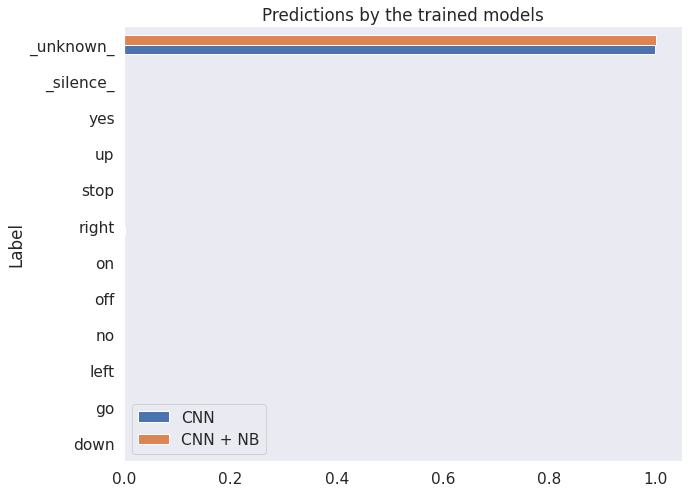

In [ ]:
##### IMPORTANT: The recorded audio is 48KHZ. I am converting it to 16KHZ. This impacts the performance severely!!!
##### Please use the python script on your desktop to test this out.

combination = True

sample_rate = 48000
new_sample_rate = 16000

samples = audio.get_array_of_samples()
samples = np.array(samples)

resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))


resampled = np.float32(resampled)

X_example = audio_to_mfcc(resampled)
X_example = X_example[np.newaxis,...,np.newaxis]


############################# FROM TEST DATA ###########################
# for i, observation in enumerate(ds_test):                            #
#   samples = tf.cast(observation['audio'], dtype = 'float32').numpy() #
#   X_example = audio_to_mfcc(samples)                                 #
#   X_example = X_example[np.newaxis,...,np.newaxis]                   #
#   label   = observation['label']                                     #
#   if i == 20:                                                        #
#     break                                                            #
# print(ds_info.features["label"].int2str(label.numpy()))              #
########################################################################

# Model 1
prediction_cnn = model_basic_cnn.predict(X_example)

# Model 2
bottleneck_features = model_cnn_for_features.predict(X_example)
prediction_cnn_nb = model_cnn_nb.predict_proba(bottleneck_features)

# Model 3
prediction_rn = model_rn.predict(X_example)

# Model 4
bottleneck_features = model_rn_for_features.predict(X_example)
prediction_rn_nb = model_rn_nb.predict_proba(bottleneck_features)


# result = np.argmax(prediction, axis=1)[0]
# print("Model prediction: {}".format(ds_info.features["label"].int2str(result)))

# outcome = ds_info.features["label"].int2str(result)

#df_prediction = pd.DataFrame(enumerate(prediction[0]), columns=['Label', 'Probability'])
df_prediction = pd.DataFrame({'Label': range(12), 
                              'CNN':prediction_cnn[0], 
                              'CNN + NB': prediction_cnn_nb[0],
                              'RN':prediction_rn[0], 
                              'RN + NB': prediction_rn_nb[0], 
                              })
df_prediction['Label'] = df_prediction['Label'].apply(ds_info.features["label"].int2str)
df_prediction = df_prediction.round(3)

ax = df_prediction.plot(x='Label', y = [
                                        'CNN', 'CNN + NB', 
                                        #'RN', 'RN + NB'
                                        ], kind = 'barh', figsize=(10,8))

ax.set_title("Predictions by the trained models")

ax.grid(False)

#Audio(samples, rate = 16000) 

In [ ]:
pd.Series(y_test).astype('int').apply(ds_info.features['label'].int2str).value_counts(normalize = True)

up           0.086912
yes          0.085685
left         0.084254
stop         0.084049
_unknown_    0.083436
_silence_    0.083436
down         0.083027
no           0.082822
go           0.082209
off          0.082209
on           0.080982
right        0.080982
dtype: float64

In [ ]:
model_basic_cnn = load_model(os.path.join(model_location, "CNN_best.h5"), compile=False)

In [ ]:
model_rn.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 22, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 8, 64)    3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 10, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________